<a href="https://colab.research.google.com/github/Hiomio/3D-Book-Slider/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [ ]:
import os

# Set the correct dataset path (based on kagglehub output)
dataset_path = "/kaggle/input/brain-tumor-mri-dataset"

# Define training and testing directories
train_dir = os.path.join(dataset_path, "Training")
test_dir = os.path.join(dataset_path, "Testing")

# Define categories
categories = ["glioma", "meningioma", "notumor", "pituitary"]

# Check existence of folders
print("Train directory exists:", os.path.exists(train_dir))
print("Test directory exists:", os.path.exists(test_dir))
print("Categories in Training:", os.listdir(train_dir) if os.path.exists(train_dir) else "Not Found")


Train directory exists: True
Test directory exists: True
Categories in Training: ['pituitary', 'notumor', 'meningioma', 'glioma']


In [ ]:
import os

train_dir = "/kaggle/input/brain-tumor-mri-dataset/Training"
print("Train directory exists:", os.path.exists(train_dir))

Train directory exists: True


In [ ]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Downloaded to:", path)


Downloaded to: /kaggle/input/brain-tumor-mri-dataset


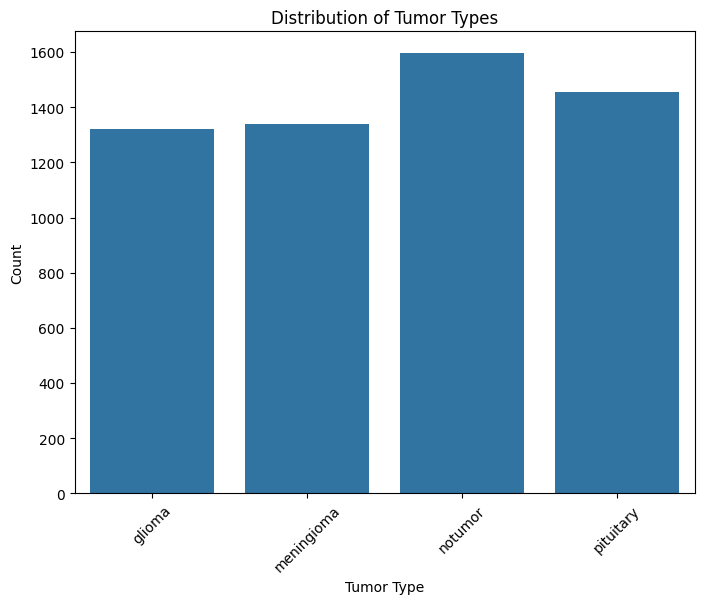

In [ ]:
train_data = []
for category in categories:
    folder_path = os.path.join(train_dir, category)

    # Check if category folder exists
    if not os.path.exists(folder_path):
        print(f"Skipping missing folder: {folder_path}")
        continue

    images = os.listdir(folder_path)

    # Check for empty folders
    if not images:
        print(f"Warning: No images found in {folder_path}. Skipping.")
        continue

    count = len(images)
    train_data.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

# Ensure we have data before concatenation
if train_data:
    train_df = pd.concat(train_data, ignore_index=True)

    # Visualize the distribution of tumor types
    plt.figure(figsize=(8, 6))
    sns.barplot(data=train_df, x="Category", y="Count")
    plt.title("Distribution of Tumor Types")
    plt.xlabel("Tumor Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No valid images found in training dataset.")

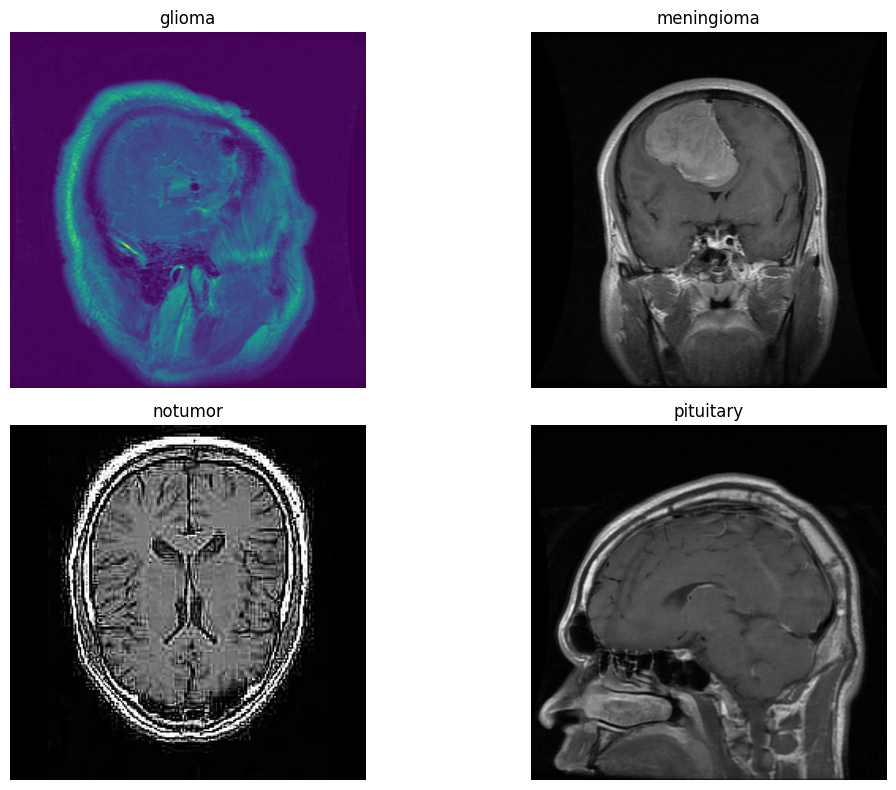

In [ ]:
# Visualize sample images for each tumor type
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    folder_path = os.path.join(train_dir, category)
    image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = plt.imread(image_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Set the image size
image_size = (150, 150)

# Set the batch size for training
batch_size = 32

# Set the number of epochs for training
epochs = 50

In [ ]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(len(categories), activation="softmax")
])

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

Epoch 1/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.5233 - loss: 1.0502 - val_accuracy: 0.6508 - val_loss: 0.9810
Epoch 2/50
  1/178 ━━━━━━━━━━━━━━━━━━━━ 4:18 1s/step - accuracy: 0.7500 - loss: 0.6564

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


178/178 ━━━━━━━━━━━━━━━━━━━━ 41s 223ms/step - accuracy: 0.7500 - loss: 0.6564 - val_accuracy: 0.6844 - val_loss: 0.8677
Epoch 3/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.7042 - loss: 0.7278 - val_accuracy: 0.4961 - val_loss: 1.4776
Epoch 4/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 22s 117ms/step - accuracy: 0.7188 - loss: 0.6952 - val_accuracy: 0.4586 - val_loss: 1.6434
Epoch 5/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.7579 - loss: 0.6215 - val_accuracy: 0.5477 - val_loss: 1.3746
Epoch 6/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 43s 234ms/step - accuracy: 0.7500 - loss: 0.7345 - val_accuracy: 0.5273 - val_loss: 1.4632
Epoch 7/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.7889 - loss: 0.5480 - val_accuracy: 0.7711 - val_loss: 0.5537
Epoch 8/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 41s 225ms/step - accuracy: 0.7500 - loss: 0.6721 - val_accuracy: 0.7664 - val_loss: 0.5477
Epoch 9/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.8137 - loss: 0.4872 - val_accurac